In [5]:
import re
from pathlib import Path
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def parse_and_plot_matrices(
    *,
    n_features: int,                 # <-- new REQUIRED argument
    file_path: str = "",
    raw_text: str = "",
) -> Dict[int, np.ndarray]:
    """
    Parse projection matrices from the new edge-list log format (and the old
    dense format for backward compatibility) and plot them.

    Parameters
    ----------
    n_features : int   (required)
        Total number of numerical features in the data set.  Every matrix will
        have exactly this number of columns.
    file_path : str
        Path to the log file.  Ignored if `raw_text` is provided.
    raw_text : str
        The log content as a string.

    Returns
    -------
    dict[int, np.ndarray]
        Mapping  node_id -> (n_projections × n_features) numpy matrix.
    """
    if n_features <= 0:
        raise ValueError("n_features must be a positive integer")

    # ------------------------------------------------------------------ #
    # 1.  Load text                                                      #
    # ------------------------------------------------------------------ #
    text = raw_text if raw_text else Path(file_path).read_text()

    # ------------------------------------------------------------------ #
    # 2.  Parse                                                          #
    # ------------------------------------------------------------------ #
    def parse_matrices(text_: str) -> Dict[int, np.ndarray]:
        matrices: Dict[int, np.ndarray] = {}

        # --- new edge-list blocks --------------------------------------
        node_re = re.compile(
            r"Node\s+(\d+)\s*\|\s*(\d+)\s+projections(.*?)(?=Node\s+\d+\s*\||\Z)",
            re.S,
        )

        for node_id_str, n_proj_str, block in node_re.findall(text_):
            node_id = int(node_id_str)
            n_proj = int(n_proj_str)

            mat = np.zeros((n_proj, n_features), dtype=int)

            for line in block.strip().splitlines():
                tokens = line.strip().split()
                if len(tokens) == 3 and tokens[0].isdigit():
                    p, f, w = map(int, tokens)
                    if not (0 <= f < n_features):
                        raise ValueError(
                            f"Feature index {f} in node {node_id} "
                            f"exceeds n_features-1 = {n_features-1}"
                        )
                    if not (0 <= p < n_proj):
                        raise ValueError(
                            f"Projection index {p} in node {node_id} "
                            f"exceeds n_proj-1 = {n_proj-1}"
                        )
                    mat[p, f] = w

            matrices[node_id] = mat

        # --- old dense "proj…" blocks (optional) -----------------------
        old_re = re.compile(r"Node\s+(\d+)(.*?proj.*?)(?=Node\s+\d+|$)", re.S)
        for node_id_str, block in old_re.findall(text_):
            node_id = int(node_id_str)
            rows = []
            for line in block.splitlines():
                line = line.strip()
                if line.startswith("proj"):
                    values = list(map(int, line.split()[2:]))
                    rows.append(values)

            if rows:
                dense = np.asarray(rows, dtype=int)
                if dense.shape[1] > n_features:
                    raise ValueError(
                        f"Old-format matrix for node {node_id} has "
                        f"{dense.shape[1]} columns, exceeds n_features={n_features}"
                    )
                # pad to n_features on the right
                pad_width = n_features - dense.shape[1]
                if pad_width:
                    dense = np.pad(dense, ((0, 0), (0, pad_width)))
                matrices[node_id] = dense

        return matrices

    matrices = parse_matrices(text)

    # ------------------------------------------------------------------ #
    # 3.  Diagnostics that stay up-front                                 #
    # ------------------------------------------------------------------ #
    if matrices:
        print(f"Using n_features = {n_features}")
        first_shape = next(iter(matrices.values())).shape
        print(f"Example matrix dimensions: {first_shape}")
        print(f"Parsed {len(matrices)} nodes:", list(matrices.keys()))

    # ------------------------------------------------------------------ #
    # 4.  Plotting (now with per-matrix diagnostics)                     #
    # ------------------------------------------------------------------ #
    cmap = ListedColormap(["orange", "white", "green"])
    for node, mat in matrices.items():
        # ------------- diagnostics -----------------
        nonzeros = np.count_nonzero(mat, axis=1)
        print(f"\nNode {node}: average non-zeros / row = {nonzeros.mean():.3f}")
        print("Number of non-zeros in matrix:", nonzeros.sum())
        print("Matrix dimensions: ", mat.shape)

        # ------------- figure with two side-by-side axes -------------
        fig, (ax0, ax1) = plt.subplots(
            1, 2, figsize=(12, 4),  # width, height; tweak to taste
            gridspec_kw={"width_ratios": [3, 2]}  # make heat-map a bit wider
        )

        # ---- left pane: heat-map ------------------------------------
        im = ax0.imshow(mat, aspect="auto", cmap=cmap,
                        interpolation="none", vmin=-1, vmax=1)
        ax0.set_title(f"Node {node}")
        ax0.set_xlabel("feature")
        ax0.set_ylabel("projection")
        ax0.set_xticks(range(n_features))
        ax0.set_yticks(range(mat.shape[0]))

        cbar = fig.colorbar(im, ax=ax0, ticks=[-1, 0, 1])
        cbar.set_label("Projection weight")
        cbar.ax.set_yticklabels(["-1", "0", "1"])

        # ---- right pane: histogram ----------------------------------
        bins = np.arange(9) - 0.5          # 0–8 inclusive, centred on ints
        ax1.hist(nonzeros, bins=bins, color="cornflowerblue", edgecolor="k")
        ax1.set_xticks(range(0, 8))
        ax1.set_xlabel("non-zero count distribution")
        ax1.set_ylabel("count")
        ax1.set_title(f"Distribution of nonzeros. Total nonzeros = {nonzeros.sum()}")

        # ---- final touches & show -----------------------------------
        fig.tight_layout()
        plt.show()
        plt.close(fig)

    return matrices

Using n_features = 2523
Example matrix dimensions: (51, 2523)
Parsed 13 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Node 0: average non-zeros / row = 1.510
Number of non-zeros in matrix: 77
Matrix dimensions:  (51, 2523)


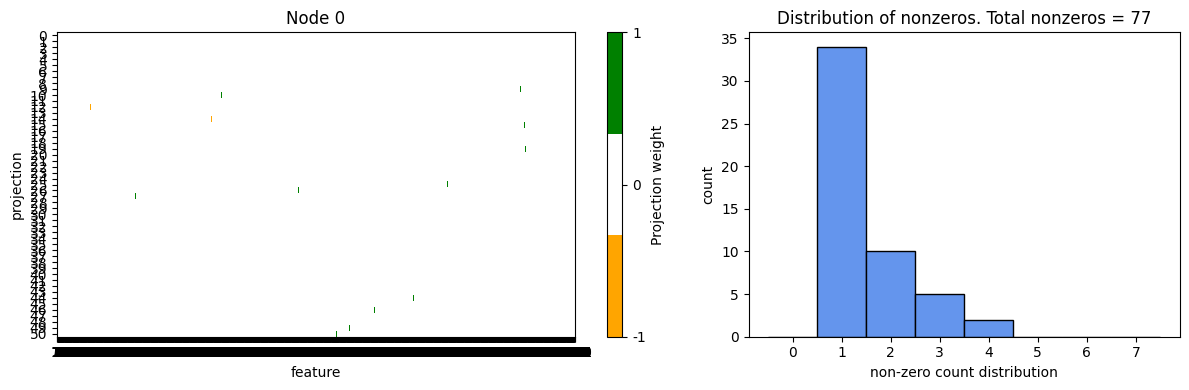


Node 1: average non-zeros / row = 1.627
Number of non-zeros in matrix: 83
Matrix dimensions:  (51, 2523)


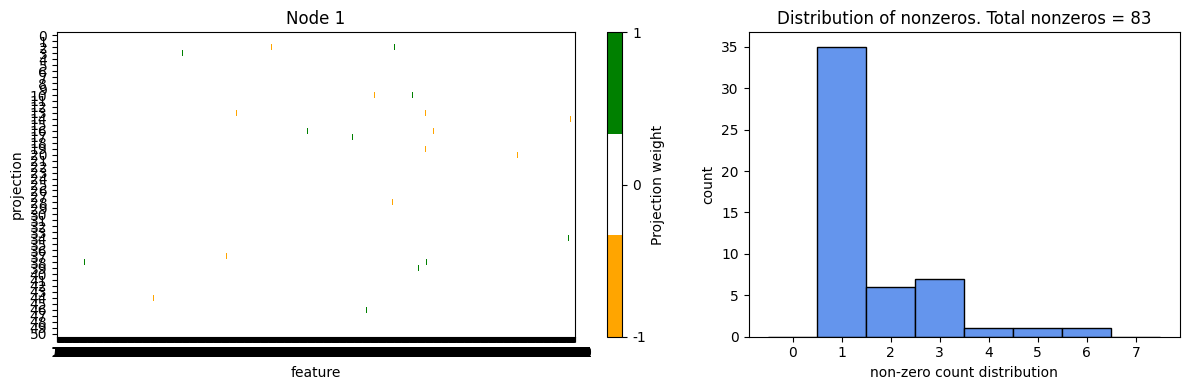


Node 2: average non-zeros / row = 1.745
Number of non-zeros in matrix: 89
Matrix dimensions:  (51, 2523)


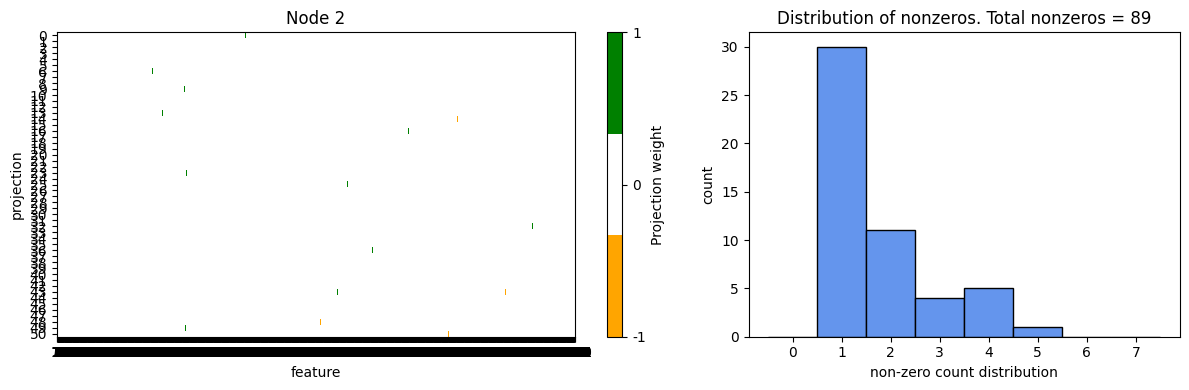


Node 3: average non-zeros / row = 1.784
Number of non-zeros in matrix: 91
Matrix dimensions:  (51, 2523)


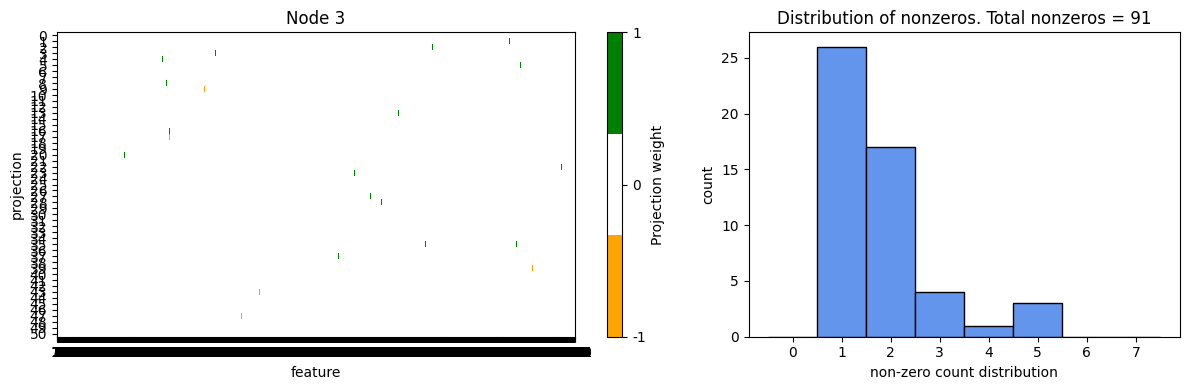


Node 4: average non-zeros / row = 1.922
Number of non-zeros in matrix: 98
Matrix dimensions:  (51, 2523)


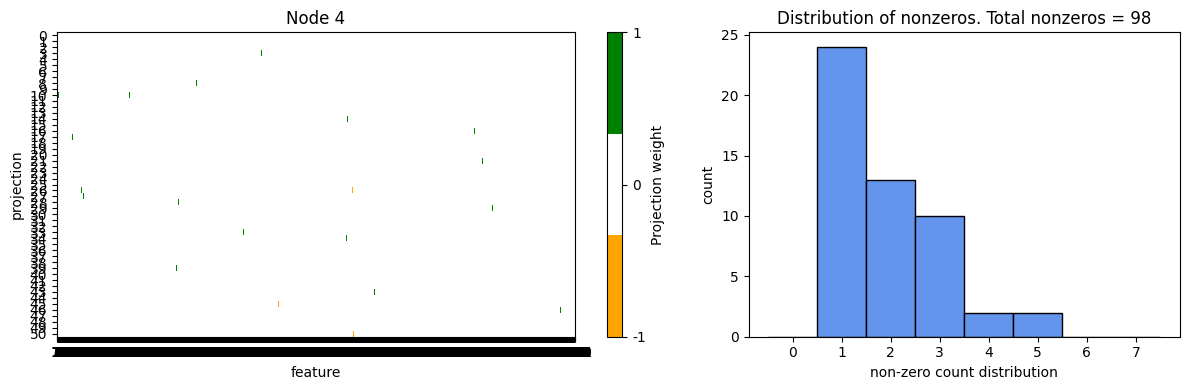


Node 5: average non-zeros / row = 1.529
Number of non-zeros in matrix: 78
Matrix dimensions:  (51, 2523)


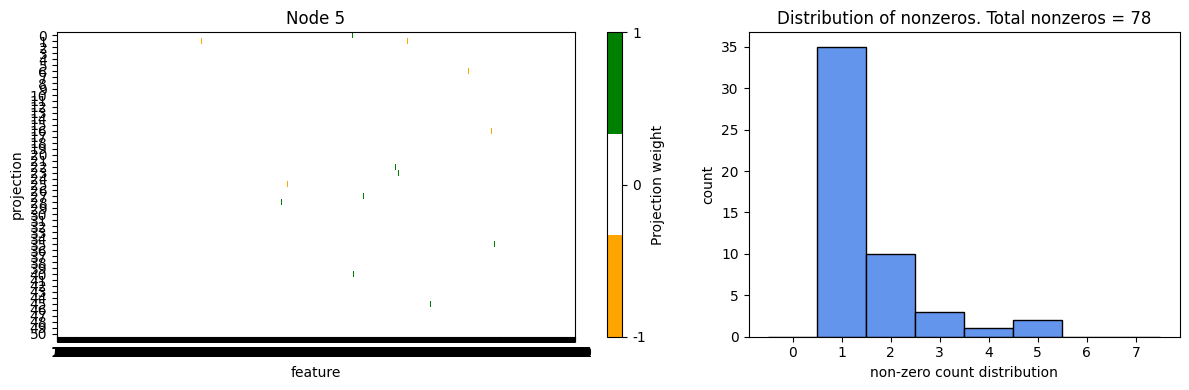


Node 6: average non-zeros / row = 1.804
Number of non-zeros in matrix: 92
Matrix dimensions:  (51, 2523)


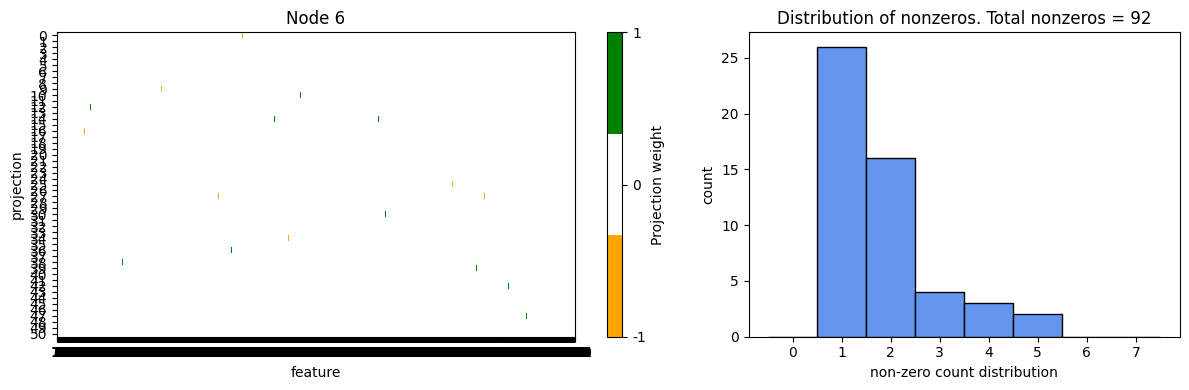


Node 7: average non-zeros / row = 1.667
Number of non-zeros in matrix: 85
Matrix dimensions:  (51, 2523)


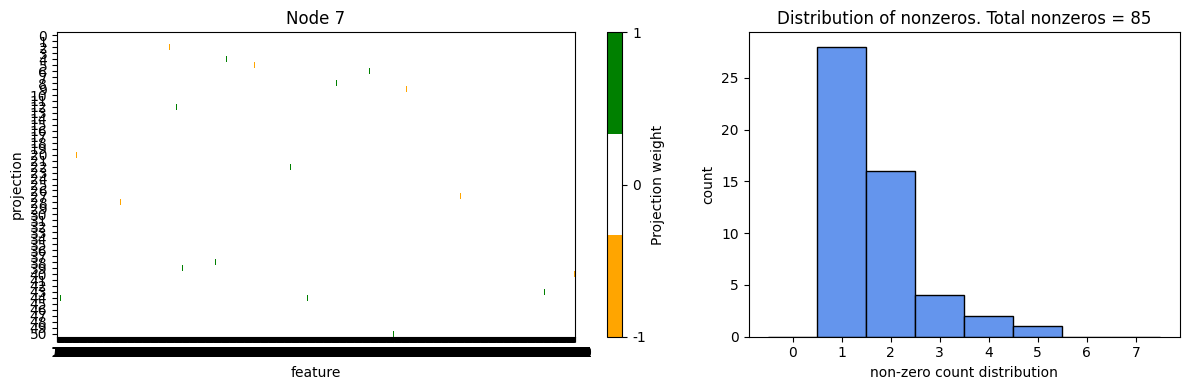


Node 8: average non-zeros / row = 1.627
Number of non-zeros in matrix: 83
Matrix dimensions:  (51, 2523)


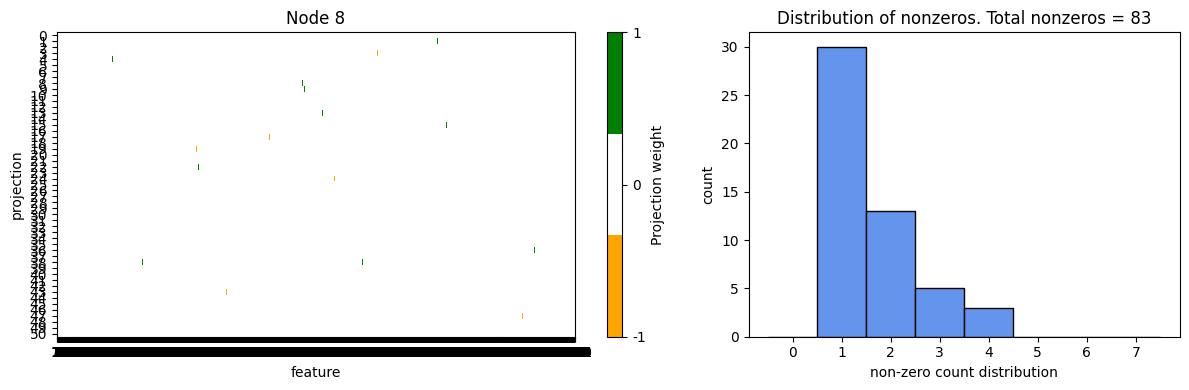


Node 9: average non-zeros / row = 1.824
Number of non-zeros in matrix: 93
Matrix dimensions:  (51, 2523)


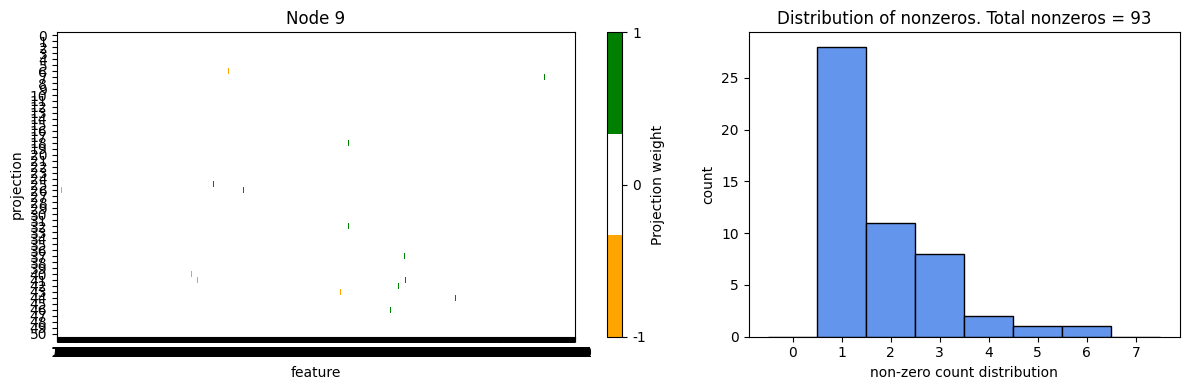


Node 10: average non-zeros / row = 1.686
Number of non-zeros in matrix: 86
Matrix dimensions:  (51, 2523)


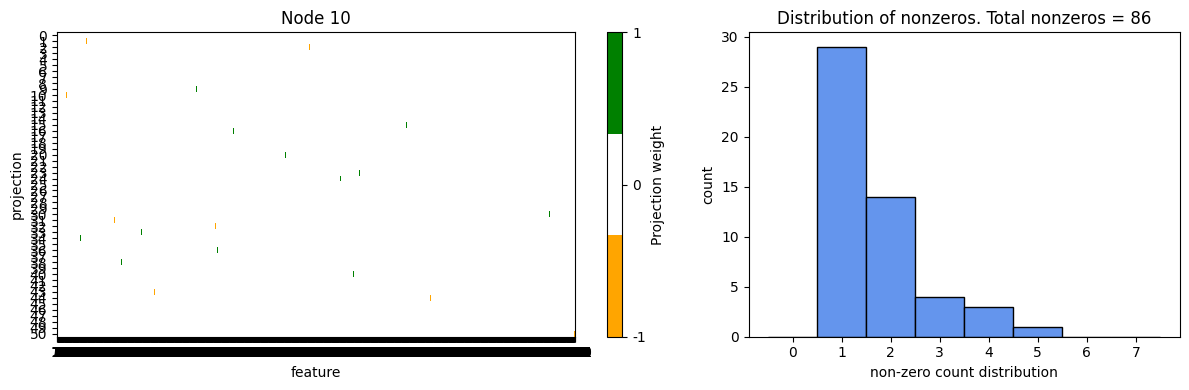


Node 11: average non-zeros / row = 1.725
Number of non-zeros in matrix: 88
Matrix dimensions:  (51, 2523)


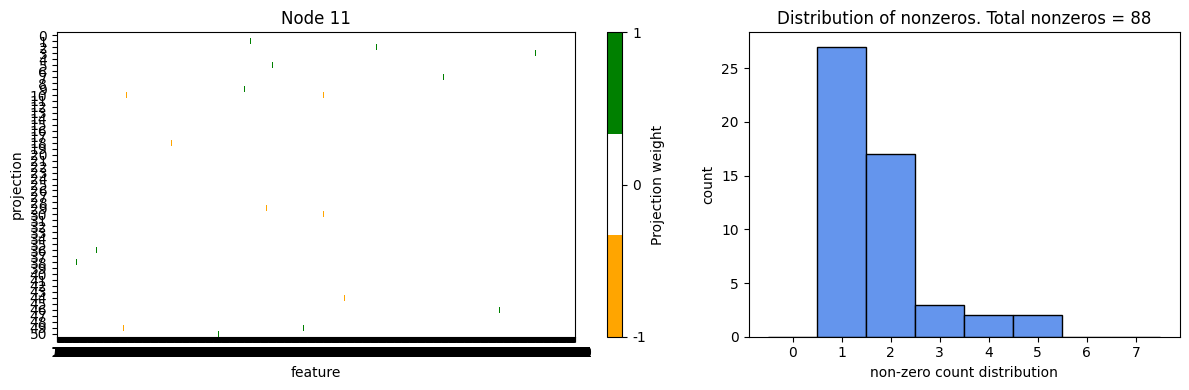


Node 12: average non-zeros / row = 1.627
Number of non-zeros in matrix: 83
Matrix dimensions:  (51, 2523)


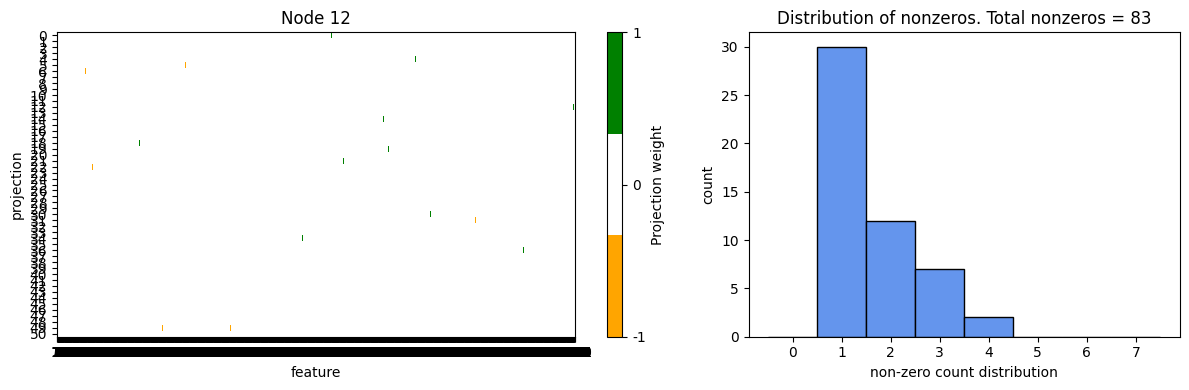

In [6]:
_ = parse_and_plot_matrices(file_path="../results/ydf_projection_matrices/projection_matrices.txt", n_features=2523)

In [21]:
import re
from pathlib import Path
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# --------------------------------------------------------------------------- #
# Helper functions for the ridge plots                                        #
# --------------------------------------------------------------------------- #
def _gaussian_kernel_1d(radius: int = 4, sigma: float = 1.2) -> np.ndarray:
    """Return a 1-D Gaussian kernel that sums to one."""
    x = np.arange(-radius, radius + 1, dtype=float)
    k = np.exp(-(x**2) / (2.0 * sigma * sigma))
    return k / k.sum()


def _ridge_plot(
    data: Dict[int, np.ndarray],
    *,
    n_features: int,
    nodes: list[int],
    kde: bool = True,
) -> None:
    """
    Draw a ridge plot of “#non-zeros per row” for the given nodes.
    The x-axis is fixed to 0–8 for easier comparison.
    
    NOTE:  Nodes are shown top-to-bottom in the same order they appear
           in `nodes` (so node[0] is now at the *top* of the stack).
    """
    # ------------------------------------------------------------------ #
    # 1.  Histogram binning                                              #
    # ------------------------------------------------------------------ #
    if kde:
        step = 0.25           # finer grid for smoother appearance
    else:
        step = 0.5            # coarser grid (matches raw histograms)

    bins        = np.arange(-0.5, 8.5 + step, step)
    bin_centres = 0.5 * (bins[:-1] + bins[1:])

    histograms = {}
    for node in nodes:
        counts, _ = np.histogram(
            np.count_nonzero(data[node], axis=1), bins=bins, density=True
        )
        if kde:
            counts = np.convolve(
                counts, _gaussian_kernel_1d(radius=5, sigma=1.0), mode="same"
            )
        histograms[node] = counts

    # ------------------------------------------------------------------ #
    # 2.  Plotting (node[0] at the top)                                  #
    # ------------------------------------------------------------------ #
    nodes_top_down = list(nodes)[::-1]      # flip order → first node on top
    colours = plt.cm.viridis(
        np.linspace(0.15, 0.85, len(nodes_top_down))
    )

    fig, ax = plt.subplots(figsize=(8, 6))

    vshift = 1.15
    for i, (node, colour) in enumerate(zip(nodes_top_down, colours)):
        y0 = i * vshift
        y  = histograms[node] + y0
        ax.fill_between(bin_centres, y0, y, color=colour, alpha=0.6)
        ax.plot(bin_centres, y, color="k", lw=0.9)
        ax.text(
            -0.7, y0 + 0.03, f"Node {node}", ha="right", va="bottom", fontsize=9
        )

    ax.set_xlim(-0.5, 8.5)
    ax.set_xlabel("# non-zeros per projection row")
    ax.set_yticks([])
    ax.set_title(
        f"Ridge plot ({'KDE' if kde else 'hist'}) – first {len(nodes)} nodes"
    )

    plt.tight_layout()
    plt.show()
    plt.close(fig)


# --------------------------------------------------------------------------- #
# Main function                                                               #
# --------------------------------------------------------------------------- #
def parse_and_plot_matrices(
    *,
    n_features: int,
    file_path: str = "",
    raw_text: str = "",
) -> Dict[int, np.ndarray]:
    """
    Parse projection matrices and create diagnostics/plots.
    """
    if n_features <= 0:
        raise ValueError("n_features must be a positive integer")

    # 1. Load text ---------------------------------------------------------
    text = raw_text if raw_text else Path(file_path).read_text()

    # 2. Parse -------------------------------------------------------------
    def parse_matrices(text_: str) -> Dict[int, np.ndarray]:
        matrices: Dict[int, np.ndarray] = {}

        # new edge-list blocks
        node_re = re.compile(
            r"Node\s+(\d+)\s*\|\s*(\d+)\s+projections(.*?)(?=Node\s+\d+\s*\||\Z)",
            re.S,
        )

        for node_id_str, n_proj_str, block in node_re.findall(text_):
            node_id, n_proj = int(node_id_str), int(n_proj_str)
            mat = np.zeros((n_proj, n_features), dtype=int)

            for line in block.strip().splitlines():
                tokens = line.strip().split()
                if len(tokens) == 3 and tokens[0].isdigit():
                    p, f, w = map(int, tokens)
                    if not (0 <= f < n_features) or not (0 <= p < n_proj):
                        raise ValueError("Index out of range in node %s" % node_id)
                    mat[p, f] = w
            matrices[node_id] = mat

        # optional old dense blocks
        old_re = re.compile(r"Node\s+(\d+)(.*?proj.*?)(?=Node\s+\d+|$)", re.S)
        for node_id_str, block in old_re.findall(text_):
            node_id = int(node_id_str)
            rows = [
                list(map(int, line.strip().split()[2:]))
                for line in block.splitlines()
                if line.strip().startswith("proj")
            ]
            if rows:
                dense = np.asarray(rows, dtype=int)
                if dense.shape[1] > n_features:
                    raise ValueError(
                        f"Dense matrix for node {node_id} has "
                        f"{dense.shape[1]} columns (exceeds n_features={n_features})"
                    )
                pad = n_features - dense.shape[1]
                if pad:
                    dense = np.pad(dense, ((0, 0), (0, pad)))
                matrices[node_id] = dense

        return matrices

    matrices = parse_matrices(text)

    # 3. Diagnostics summary ----------------------------------------------
    if matrices:
        print(f"Using n_features = {n_features}")
        first_shape = next(iter(matrices.values())).shape
        print(f"Example matrix dimensions: {first_shape}")
        print(f"Parsed {len(matrices)} nodes: {sorted(matrices)[:10]}{' …' if len(matrices)>10 else ''}")

    # 4. Per-node histograms (only first 15) ------------------------------
    nodes_for_hist = sorted(matrices.keys())[:15]
    for node in nodes_for_hist:
        mat = matrices[node]
        nonzeros = np.count_nonzero(mat, axis=1)
        avg_nnz  = nonzeros.mean()
        plt.hist(nonzeros, range=(0, 8))
        plt.title(f"Node {node} – histogram (#non-zeros/row, avg={avg_nnz:.2f})")
        plt.xlabel("# non-zeros / row")
        plt.ylabel("count")
        plt.show()
        plt.close()

    if len(matrices) > 15:
        print(f"Only plotted 15 / {len(matrices)} nodes' histograms.")

    # 5. Ridge plots (first 8 nodes) --------------------------------------
    if matrices:
        first_eight = sorted(matrices.keys())[:8]
        _ridge_plot(matrices, n_features=n_features, nodes=first_eight, kde=True)
        _ridge_plot(matrices, n_features=n_features, nodes=first_eight, kde=False)

    return matrices

Using n_features = 2523
Example matrix dimensions: (51, 2523)
Parsed 49 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] …


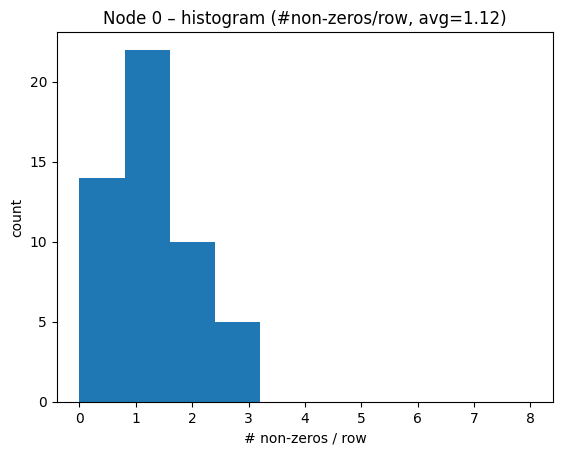

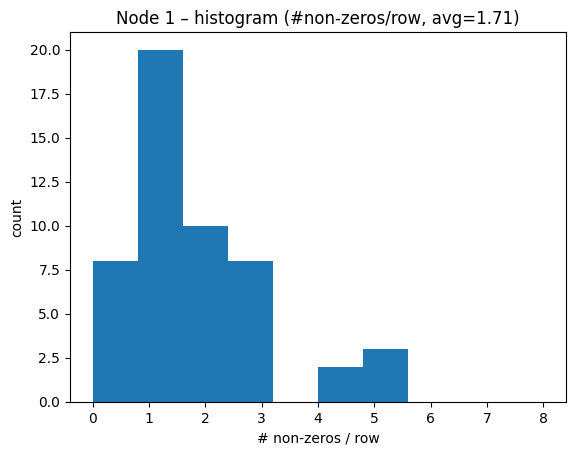

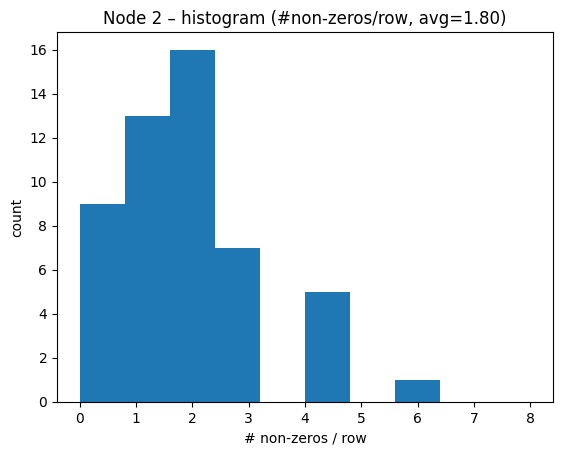

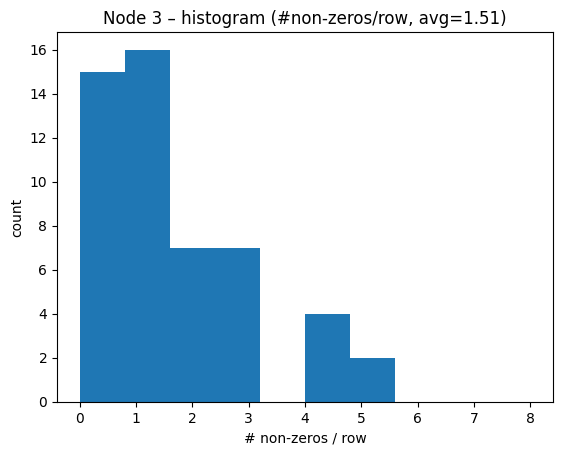

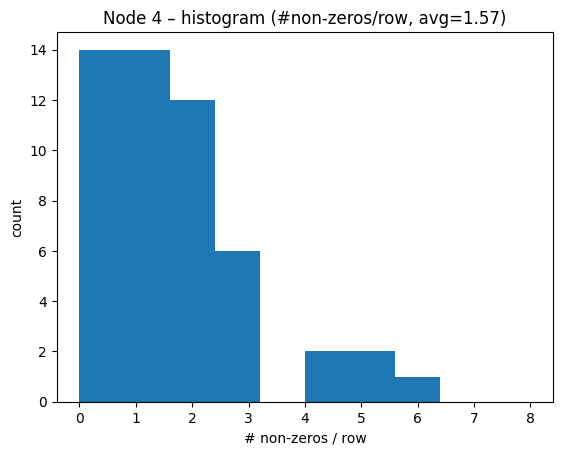

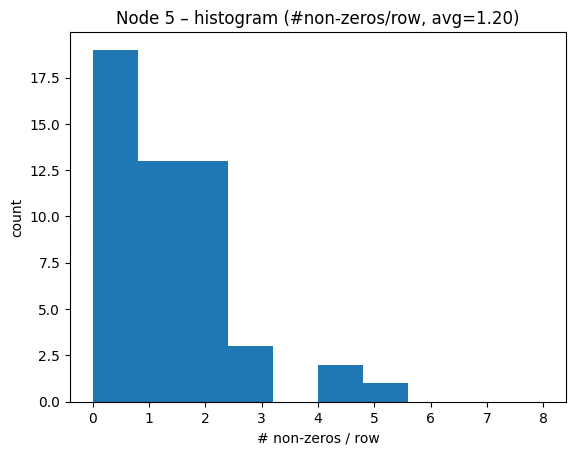

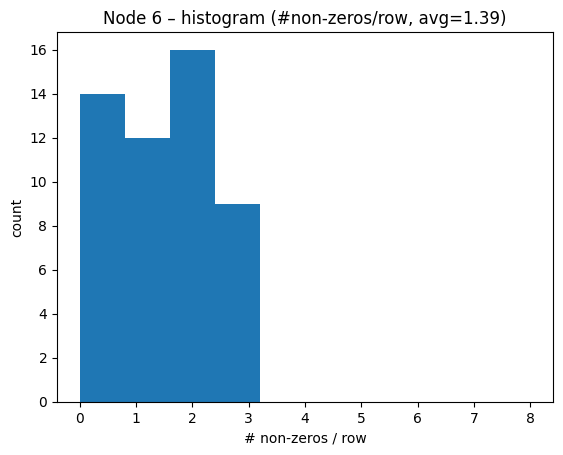

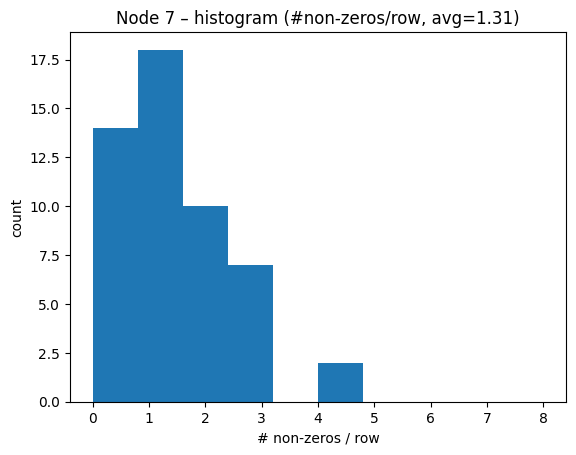

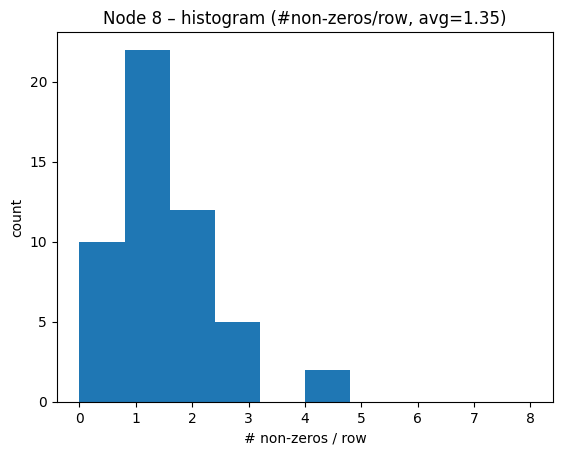

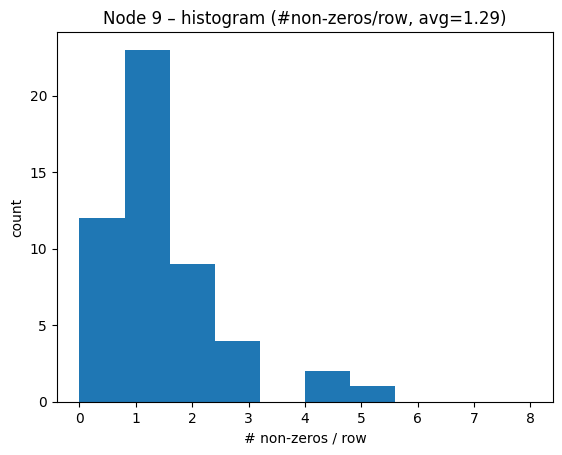

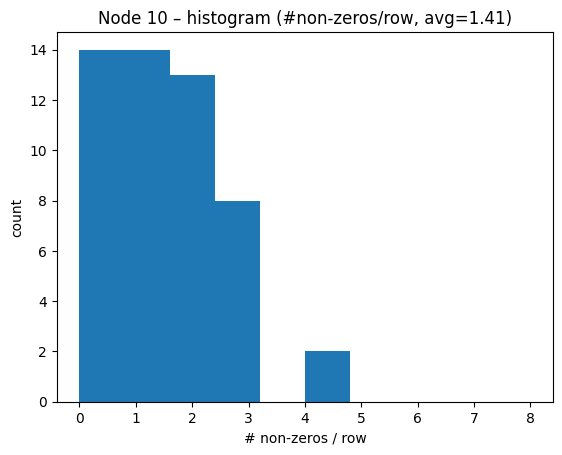

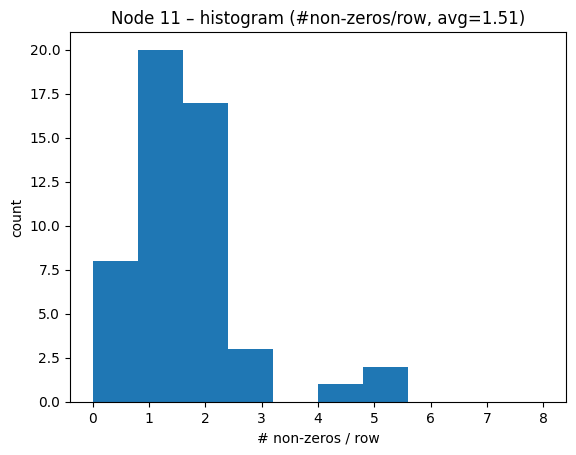

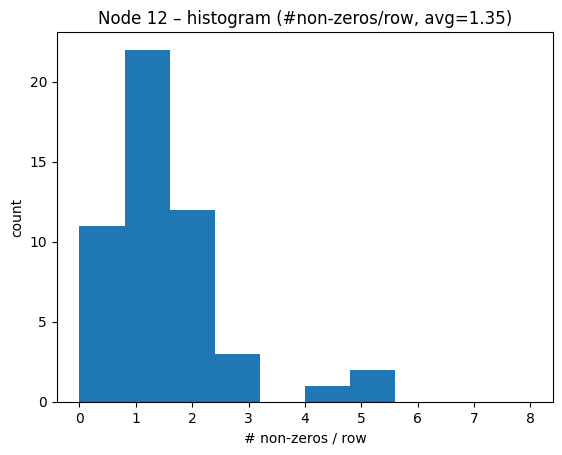

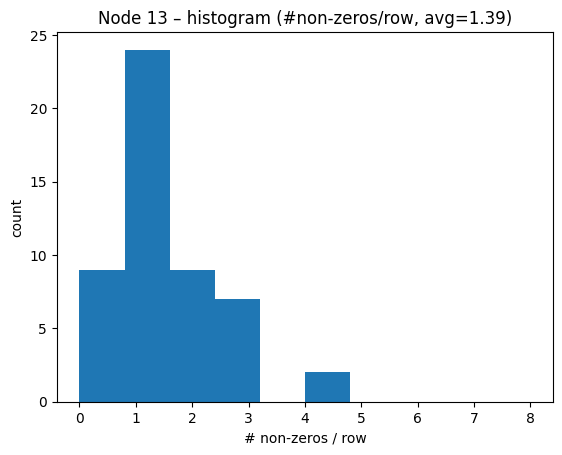

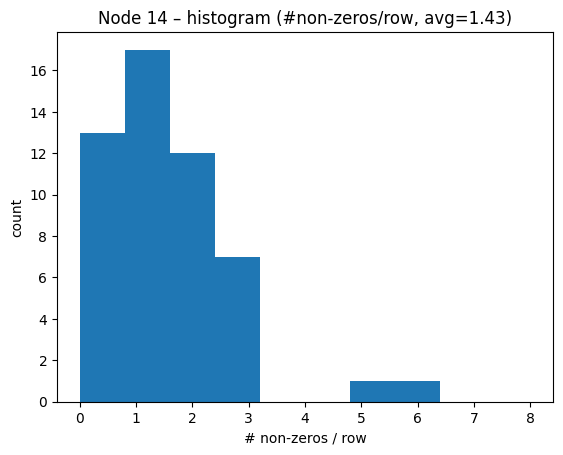

Only plotted 15 / 49 nodes' histograms.


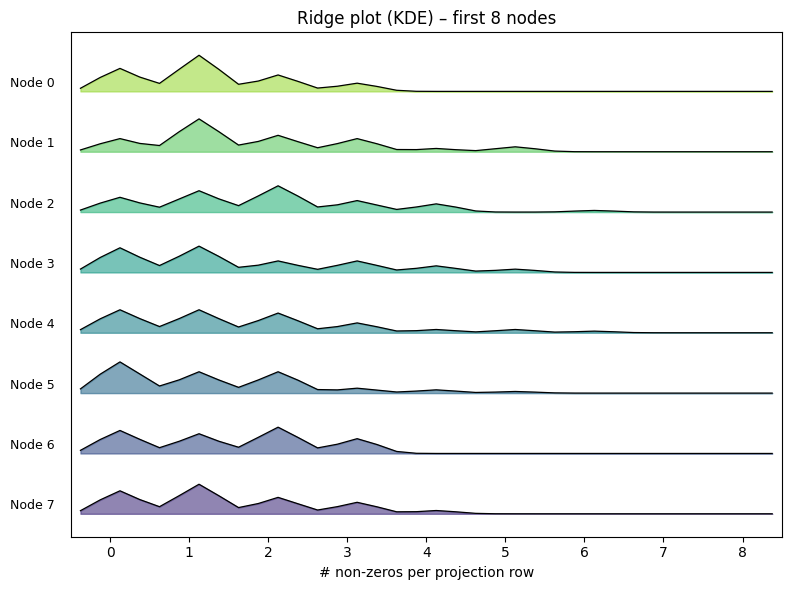

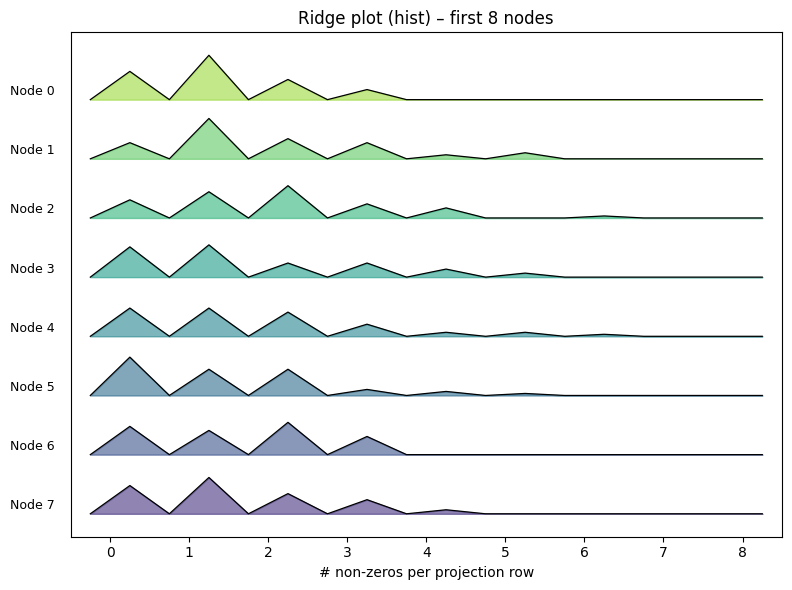

In [22]:
_ = parse_and_plot_matrices(file_path="../results/ydf_projection_matrices/projection_matrices_might_allow_empty.txt", n_features=2523)